In [41]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

In [42]:
df = pd.read_csv("data/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Preprocessing

In [43]:
#from google.colab import drive
#drive.mount('/content/drive')

#### Fill missing values and convert to numerical (where possible)

In [44]:
sexes = sorted(df['Sex'].unique())
sexes_mapping = dict(zip(sexes, range(0, len(sexes) + 1)))
df['Sex_Val'] = df['Sex'].map(sexes_mapping).astype(int)

In [45]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
embarked_locs = sorted(df['Embarked'].unique())
embarked_locs_mapping = dict(zip(embarked_locs, range(0, len(embarked_locs) + 1)))
df['Embarked_Val'] = df['Embarked'].map(embarked_locs_mapping).astype(int)

In [46]:
df['AgeFill'] = df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

In [47]:
df['FamilySize'] = df['SibSp'] + df['Parch']

In [48]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Val,Embarked_Val,AgeFill,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,2,22.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,38.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,2,26.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,2,35.0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,2,35.0,0


#### Check categorical variables

In [49]:
df.dtypes[df.dtypes.map(lambda x: x == 'object')]

,0
Name,object
Sex,object
Ticket,object
Cabin,object
Embarked,object


In [50]:
df_train = df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)
df_train.drop(['Survived', 'Age', 'SibSp', 'Parch', 'PassengerId', 'Embarked_Val', 'Sex_Val'], axis=1, inplace=True)
df_train.dtypes

,0
Pclass,int64
Fare,float64
AgeFill,float64
FamilySize,int64


In [51]:
df_train.head()

,Pclass,Fare,AgeFill,FamilySize
0,3,7.2500,22.0,1
1,1,71.2833,38.0,1
2,3,7.9250,26.0,0
3,1,53.1000,35.0,1
4,3,8.0500,35.0,0


In [52]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(df_train)

### Clustering

In [53]:
from sklearn.metrics import *
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [17]:
%%time
sse_list = []
sil_list = []

for k in range(2, 51):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(train_data)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(train_data, kmeans.labels_))

CPU times: user 9.45 s, sys: 44.5 ms, total: 9.5 s
Wall time: 5.31 s


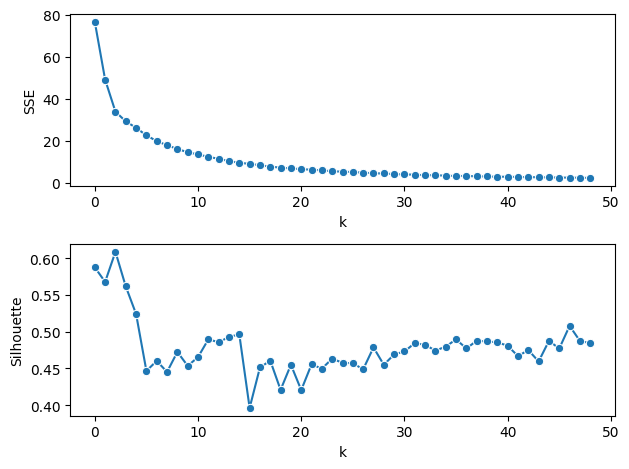

In [18]:
fig, axs = plt.subplots(2) # 1 row, 2 columns

sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')
sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout() # Adjust the padding between and around subplots

In [22]:
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10, max_iter=100)
kmeans.fit(train_data)

KMeans(max_iter=100, n_clusters=5, n_init=10)

In [23]:
print('labels', np.unique(kmeans.labels_, return_counts=True))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(train_data, kmeans.labels_))

labels (array([0, 1, 2, 3, 4], dtype=int32), array([433, 109, 184,  58, 107]))
sse 29.169946054563958
silhouette 0.5614640538880703


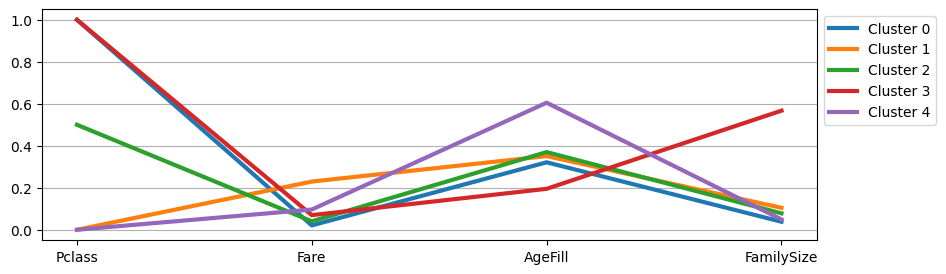

In [24]:
plt.figure(figsize=(10, 3))

for i in range(len(kmeans.cluster_centers_)):
    plt.plot(range(0, 4), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(0, 4), list(df_train.columns))
plt.legend(bbox_to_anchor=(1,1))
plt.grid(axis='y')
plt.show()

In [25]:
df_clusters = df_train.copy()
df_clusters['Labels'] = kmeans.labels_

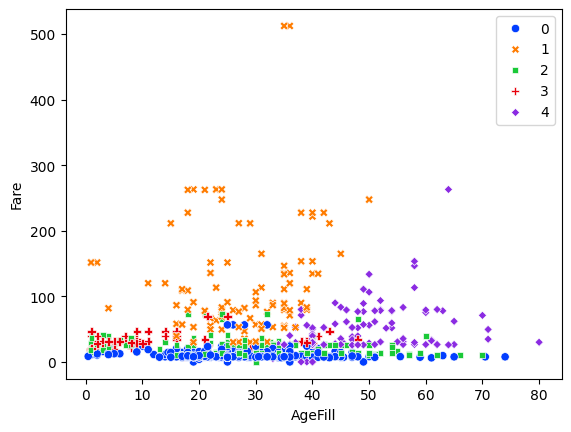

In [26]:
sns.scatterplot(data=df_clusters,
                x="AgeFill",
                y="Fare",
                hue=kmeans.labels_,
                style=kmeans.labels_,
                palette="bright")
plt.show()

In [27]:
df_clusters.head()

,Pclass,Fare,AgeFill,FamilySize,Labels
0,3,7.2500,22.0,1,0
1,1,71.2833,38.0,1,4
2,3,7.9250,26.0,0,0
3,1,53.1000,35.0,1,1
4,3,8.0500,35.0,0,0


In [28]:
pclass_xt = pd.crosstab(df_clusters['Pclass'], df_clusters['Labels'])
pclass_xt

Labels,0,1,2,3,4
Pclass,,,,,
1,0,109,0,0,107
2,0,0,184,0,0
3,433,0,0,58,0


In [29]:
psurv_xt = pd.crosstab(df_clusters['Labels'], df['Survived'])
psurv_xt

Survived,0,1
Labels,,
0,322,111
1,21,88
2,97,87
3,50,8
4,59,48


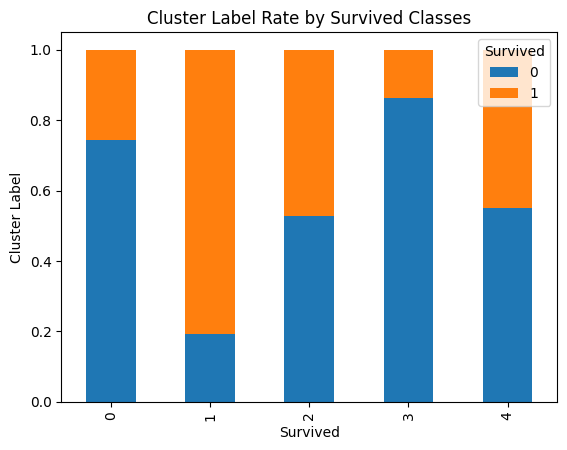

In [30]:
psurv_xt_pct = psurv_xt.div(psurv_xt.sum(1).astype(float), axis=0)
psurv_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by Survived Classes')
plt.xlabel('Survived')
plt.ylabel('Cluster Label')
plt.show()

In [31]:
df_clusters[df_clusters['Labels']==1].describe()

,Pclass,Fare,AgeFill,FamilySize,Labels
count,109.0,109.000000,109.000000,109.000000,109.0
mean,1.0,118.044533,28.256147,1.045872,1.0
std,0.0,92.682510,9.034489,1.173672,0.0
min,1.0,26.283300,0.920000,0.000000,1.0
25%,1.0,56.929200,22.000000,0.000000,1.0
50%,1.0,86.500000,29.000000,1.000000,1.0
75%,1.0,146.520800,35.000000,1.000000,1.0
max,1.0,512.329200,50.000000,5.000000,1.0


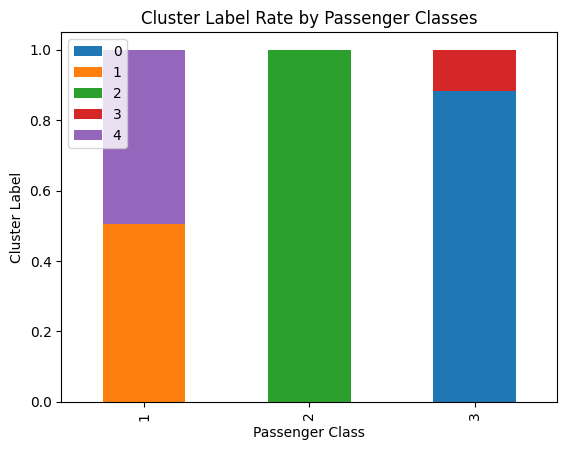

In [32]:
pclass_xt_pct = pclass_xt.div(pclass_xt.sum(1).astype(float), axis=0)
pclass_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by Passenger Classes')
plt.xlabel('Passenger Class')
plt.ylabel('Cluster Label')
plt.legend(loc='best')
plt.show()

### DBScan

In [34]:
# density based clustering
print('dbscan')

dbscan = DBSCAN(eps=0.3, min_samples=5, metric='euclidean')
dbscan.fit(train_data)

hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1]))

dbscan
labels {np.int64(-1): np.int64(4), np.int64(0): np.int64(484), np.int64(1): np.int64(212), np.int64(2): np.int64(184), np.int64(3): np.int64(7), np.int64(4): np.int64(0)}
silhouette 0.5728928528267885


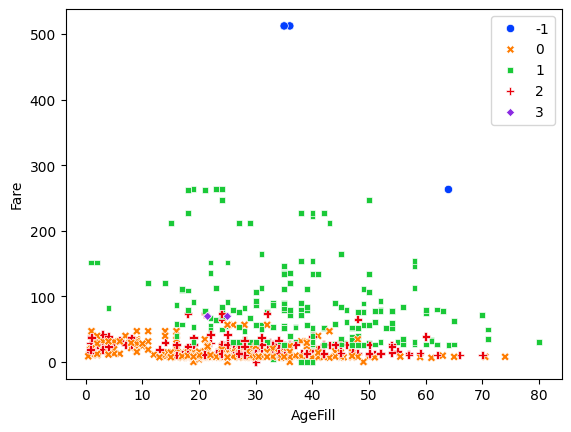

In [35]:
sns.scatterplot(data=df_clusters,
                x="AgeFill",
                y="Fare",
                hue=dbscan.labels_,
                style=dbscan.labels_,
                palette="bright")
plt.show()

### Hierarchical

In [36]:
def get_linkage_matrix(model):
    # Create linkage matrix

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

In [37]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean', linkage='complete')
model = model.fit(train_data)

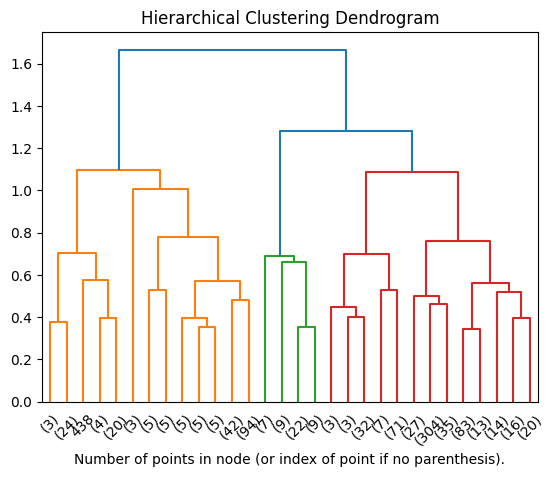

In [38]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp", color_threshold=1.2)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [39]:
# get the labels according to a specific threshold value cut
Z = get_linkage_matrix(model)
labels = fcluster(Z, t=1.2, criterion='distance')

In [40]:
labels

array([3, 1, 3, 1, 3, 3, 1, 2, 3, 3, 3, 1, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3,
       3, 1, 2, 2, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 1, 1, 3, 3, 3, 2, 3, 1, 1, 2, 1, 3,
       3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3,
       1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, 3, 3,
       3, 1, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 2, 1, 3, 1, 2, 3, 3, 1, 3,
       3, 1, 3, 3, 2, 3, 2, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3,
       3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 2, 1, 1,
       3, 3, 2, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3,

In [ ]:
print('Silhouette', silhouette_score(train_data, labels))

Silhouette 0.5026555448852588


### Choosing the number of clusters

In [ ]:
hier = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
hier.fit(train_data)

AgglomerativeClustering(linkage='complete', n_clusters=3)

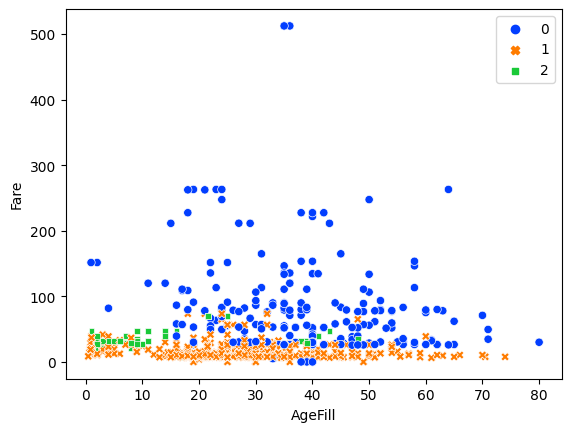

In [ ]:
sns.scatterplot(data=df_clusters,
                x="AgeFill",
                y="Fare",
                hue=hier.labels_,
                style=hier.labels_,
                palette="bright")
plt.show()

#### connectivity constraint

In [ ]:
# hierarchical clustering
# Compute the (weighted) graph of k-Neighbors for points in X
connectivity = kneighbors_graph(train_data, n_neighbors=100, include_self=False)

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                metric='euclidean',
                                linkage='ward',
                                connectivity=connectivity)

# connecet: Defines for each sample the neighboring
# samples following a given structure of the data.

model = model.fit(train_data)

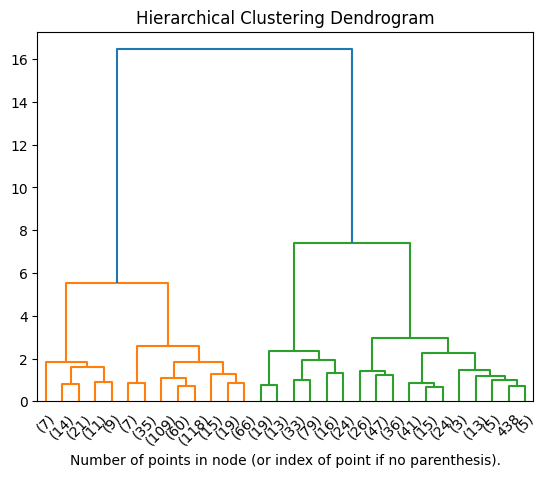

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
ward = AgglomerativeClustering(n_clusters=3,
                               linkage='ward',
                               metric='euclidean',
                               connectivity=connectivity)
ward.fit(train_data)

hist, bins = np.histogram(ward.labels_, bins=range(0, len(set(ward.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, ward.labels_))

labels {0: 491, 1: 216, 2: 184}
silhouette 0.5676262875725462


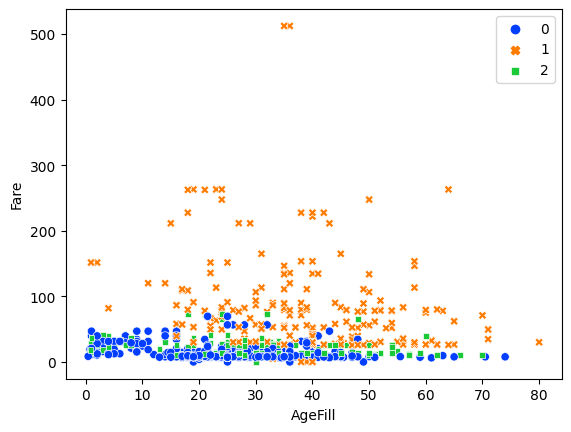

In [ ]:
sns.scatterplot(data=df_clusters,
                x="AgeFill",
                y="Fare",
                hue=ward.labels_,
                style=ward.labels_,
                palette="bright")
plt.show()

In [ ]:
print('average linkage')
average_linkage = AgglomerativeClustering(n_clusters=3, linkage='average', metric='manhattan',  connectivity=connectivity)
average_linkage.fit(train_data)

hist, bins = np.histogram(average_linkage.labels_,
                          bins=range(0, len(set(average_linkage.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, average_linkage.labels_))

average linkage
labels {0: 881, 1: 7, 2: 3}
silhouette 0.37132365914471405


In [ ]:
print('complete linkage')
complete_linkage = AgglomerativeClustering(n_clusters=3, linkage='complete', metric='l1', connectivity=connectivity)
complete_linkage.fit(train_data)

hist, bins = np.histogram(complete_linkage.labels_,
                          bins=range(0, len(set(complete_linkage.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, complete_linkage.labels_))

complete linkage
labels {0: 882, 1: 3, 2: 6}
silhouette 0.35741232675404144


### Categorical & Mixed distances

In [54]:
cols2drop = ['PassengerId', 'Name', 'Cabin', 'Ticket', 'FamilySize', 'Sex_Val', 'Embarked_Val', 'Age']
df_xm = df.drop(cols2drop, axis=1)
df_xm['Pclass'] = df_xm['Pclass'].map({1: '1st', 2: '2nd', 3: '3rd'})
df_xm.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeFill
0,0,3rd,male,1,0,7.2500,S,22.0
1,1,1st,female,1,0,71.2833,C,38.0
2,1,3rd,female,0,0,7.9250,S,26.0
3,1,1st,female,1,0,53.1000,S,35.0
4,0,3rd,male,0,0,8.0500,S,35.0


In [55]:
df_xm2 = pd.get_dummies(df_xm[[c for c in df_xm.columns if c != 'Survived']], prefix_sep='=')
df_xm2

,SibSp,Parch,Fare,AgeFill,Pclass=1st,Pclass=2nd,Pclass=3rd,Sex=female,Sex=male,Embarked=C,Embarked=Q,Embarked=S
0,1,0,7.2500,22.0,False,False,True,False,True,False,False,True
1,1,0,71.2833,38.0,True,False,False,True,False,True,False,False
2,0,0,7.9250,26.0,False,False,True,True,False,False,False,True
3,1,0,53.1000,35.0,True,False,False,True,False,False,False,True
4,0,0,8.0500,35.0,False,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,13.0000,27.0,False,True,False,False,True,False,False,True
887,0,0,30.0000,19.0,True,False,False,True,False,False,False,True
888,1,2,23.4500,21.5,False,False,True,True,False,False,False,True
889,0,0,30.0000,26.0,True,False,False,False,True,True,False,False


In [56]:
X = df_xm2[['Pclass=1st', 'Pclass=2nd',	'Pclass=3rd', 'Sex=female',	'Sex=male',	'Embarked=C', 'Embarked=Q',	'Embarked=S']].values

In [57]:
X[:5]

array([[False, False,  True, False,  True, False, False,  True],
       [ True, False, False,  True, False,  True, False, False],
       [False, False,  True,  True, False, False, False,  True],
       [ True, False, False,  True, False, False, False,  True],
       [False, False,  True, False,  True, False, False,  True]])

In [58]:
D = pdist(X, 'jaccard')
D = squareform(D)

In [59]:
D

array([[0. , 1. , 0.5, ..., 0.5, 0.8, 0.5],
       [1. , 0. , 0.8, ..., 0.8, 0.5, 1. ],
       [0.5, 0.8, 0. , ..., 0. , 1. , 0.8],
       ...,
       [0.5, 0.8, 0. , ..., 0. , 1. , 0.8],
       [0.8, 0.5, 1. , ..., 1. , 0. , 0.8],
       [0.5, 1. , 0.8, ..., 0.8, 0.8, 0. ]])

In [60]:
# Mixed custom distance

In [61]:
from scipy.spatial.distance import seuclidean, jaccard

In [ ]:
def mixed(a, b):
    index = 4
    d_con = seuclidean(a[:index], b[:index], V=np.ones(index))
    w_con = index/len(a)
    d_cat = jaccard(a[index:], b[index:])
    w_cat = (len(a)-index)/len(a)
    d = w_con * d_con + w_cat * d_cat
    return d

In [ ]:
df_xm2.head()

,SibSp,Parch,Fare,AgeFill,Pclass=1st,Pclass=2nd,Pclass=3rd,Sex=female,Sex=male,Embarked=C,Embarked=Q,Embarked=S
0,1,0,7.2500,22.0,False,False,True,False,True,False,False,True
1,1,0,71.2833,38.0,True,False,False,True,False,True,False,False
2,0,0,7.9250,26.0,False,False,True,True,False,False,False,True
3,1,0,53.1000,35.0,True,False,False,True,False,False,False,True
4,0,0,8.0500,35.0,False,False,True,False,True,False,False,True


In [ ]:
X = df_xm2.values

In [ ]:
X[:5]

array([[1, 0, 7.25, 22.0, False, False, True, False, True, False, False,
        True],
       [1, 0, 71.2833, 38.0, True, False, False, True, False, True,
        False, False],
       [0, 0, 7.925, 26.0, False, False, True, True, False, False, False,
        True],
       [1, 0, 53.1, 35.0, True, False, False, True, False, False, False,
        True],
       [0, 0, 8.05, 35.0, False, False, True, False, True, False, False,
        True]], dtype=object)

In [ ]:
mixed(X[0], X[10])

7.118140707983781

In [ ]:
D = pdist(X, mixed)
D = squareform(D)

In [ ]:
D

array([[ 0.        , 22.66733208,  1.72599765, ...,  5.77688201,
         8.24020256,  3.6874353 ],
       [22.66733208,  0.        , 22.03081168, ..., 17.41288898,
        14.6678715 , 21.94127388],
       [ 1.72599765, 22.03081168,  0.        , ...,  5.43931802,
         8.025     ,  2.53418385],
       ...,
       [ 5.77688201, 17.41288898,  5.43931802, ...,  0.        ,
         3.41848425,  6.87315457],
       [ 8.24020256, 14.6678715 ,  8.025     , ...,  3.41848425,
         0.        ,  8.21493111],
       [ 3.6874353 , 21.94127388,  2.53418385, ...,  6.87315457,
         8.21493111,  0.        ]])

### K-Mode
https://github.com/nicodv/kmodes

In [62]:
!pip install kmodes

In [ ]:
from kmodes.kmodes import KModes

In [ ]:
X = df[['Pclass', 'Sex', 'Embarked']].values

In [ ]:
X[:5]

array([[3, 'male', 'S'],
       [1, 'female', 'C'],
       [3, 'female', 'S'],
       [1, 'female', 'S'],
       [3, 'male', 'S']], dtype=object)

In [ ]:
km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=0)
clusters = km.fit_predict(X)

In [ ]:
km.cluster_centroids_

array([['3', 'female', 'S'],
       ['1', 'male', 'C'],
       ['3', 'male', 'S'],
       ['2', 'male', 'S']], dtype='<U21')

In [ ]:
km.labels_

array([2, 1, 0, 0, 2, 2, 1, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 3, 0, 0, 3, 3,
       0, 1, 0, 0, 1, 1, 0, 2, 1, 1, 0, 3, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0,
       0, 2, 2, 0, 1, 0, 2, 2, 1, 0, 1, 1, 0, 1, 0, 2, 1, 0, 1, 2, 1, 1,
       0, 2, 0, 2, 3, 0, 3, 1, 2, 2, 2, 2, 3, 0, 2, 2, 0, 1, 0, 0, 2, 2,
       0, 2, 2, 2, 1, 2, 2, 2, 1, 1, 0, 3, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0,
       1, 0, 2, 0, 0, 2, 2, 3, 1, 0, 3, 2, 1, 0, 1, 1, 2, 2, 0, 2, 1, 2,
       0, 0, 3, 1, 0, 1, 2, 1, 0, 0, 0, 2, 3, 3, 2, 0, 3, 3, 3, 0, 2, 2,
       2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 1, 2, 1, 2, 0, 2, 1, 2,
       2, 1, 3, 2, 0, 1, 2, 3, 0, 1, 0, 1, 2, 2, 0, 3, 0, 3, 1, 1, 2, 2,
       0, 0, 2, 2, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 2, 3, 2, 1, 0, 3, 1, 3,
       2, 3, 2, 2, 1, 2, 3, 2, 3, 0, 0, 2, 3, 0, 3, 0, 3, 0, 3, 3, 0, 0,
       3, 2, 1, 1, 0, 0, 1, 3, 2, 0, 1, 2, 0, 0, 1, 0, 1, 0, 2, 2, 1, 1,
       0, 3, 2, 2, 0, 0, 1, 2, 0, 1, 0, 0, 0, 3, 2, 0, 2, 2, 2, 2, 1, 1,
       2, 2, 3, 0, 0, 1, 1, 0, 2, 1, 1, 0, 1, 1, 0,